<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/9_author_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author Identification using Natural Language Processing

## Problem Statement

The goal is to identify the author of a text from a given list of possible authors using computational stylometry and machine learning techniques.

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Preprocess text data** for author identification tasks
2. **Extract stylometric features** that capture writing style
3. **Apply various text vectorization techniques** (TF-IDF, Count Vectorizer, Word2Vec)
4. **Build classification models** for author identification
5. **Evaluate and compare different approaches** for authorship attribution
6. **Understand computational stylometry** and its applications

## Introduction to Stylometry

**Stylometry** is the quantitative study of literary style through computational methods. It's based on the observation that authors tend to write in relatively consistent, recognizable, and unique ways.

### Key Stylistic Elements:
- **Vocabulary richness**: Some authors use rich vocabulary, others prefer simplicity
- **Sentence structure**: Preference for short vs. long sentences
- **Punctuation patterns**: Unique usage of semicolons, dashes, etc.
- **Word frequency**: Characteristic use of function words
- **Syntactic patterns**: Grammar and sentence construction preferences

### Applications:
- Literary analysis and attribution
- Forensic linguistics
- Plagiarism detection
- Social media analysis

## 1. Setup and Imports

In [15]:
# Install required packages

!pip install numpy pandas matplotlib seaborn nltk scikit-learn torch tqdm textstat

# Enable ipywidgets for Jupyter

!jupyter nbextension enable --py widgetsnbextension

# Download required NLTK data

import nltk

nltk_downloads = ['punkt', 'stopwords', 'wordnet','maxent_ne_chunker_tab', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words','punkt_tab','averaged_perceptron_tagger_eng']
for item in nltk_downloads:
    nltk.download(item, quiet=True)

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [16]:
# Essential imports
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Text processing
from textstat import flesch_reading_ease, flesch_kincaid_grade
import urllib.request
from io import StringIO

# Set style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Download required NLTK data
nltk_downloads = ['gutenberg', 'punkt', 'stopwords', 'averaged_perceptron_tagger', 'wordnet']
for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
    except:
        print(f"Could not download {item}")

print("Setup completed successfully!")

Setup completed successfully!


## 2. Data Collection and Preprocessing

We'll work with classic authors whose works are available through Project Gutenberg.

In [17]:
# Define our authors and their works
AUTHORS_DATA = {
    'shakespeare': {
        'name': 'William Shakespeare',
        'gutenberg_files': ['shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'shakespeare-caesar.txt']
    },
    'austen': {
        'name': 'Jane Austen',
        'gutenberg_files': ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt']
    },
    'chesterton': {
        'name': 'G.K. Chesterton',
        'gutenberg_files': ['chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt']
    }
}

# Alternative authors with direct URLs for more variety
ADDITIONAL_AUTHORS = {
    'dickens': {
        'name': 'Charles Dickens',
        'url': 'https://www.gutenberg.org/files/98/98-0.txt',  # A Tale of Two Cities
        'title': 'A Tale of Two Cities'
    },
    'twain': {
        'name': 'Mark Twain',
        'url': 'https://www.gutenberg.org/files/74/74-0.txt',   # Tom Sawyer
        'title': 'The Adventures of Tom Sawyer'
    },
    'wilde': {
        'name': 'Oscar Wilde',
        'url': 'https://www.gutenberg.org/files/174/174-0.txt', # The Picture of Dorian Gray
        'title': 'The Picture of Dorian Gray'
    }
}

print("Authors available for analysis:")
for key, value in AUTHORS_DATA.items():
    print(f"- {value['name']} ({key})")
for key, value in ADDITIONAL_AUTHORS.items():
    print(f"- {value['name']} ({key}) - {value['title']}")

Authors available for analysis:
- William Shakespeare (shakespeare)
- Jane Austen (austen)
- G.K. Chesterton (chesterton)
- Charles Dickens (dickens) - A Tale of Two Cities
- Mark Twain (twain) - The Adventures of Tom Sawyer
- Oscar Wilde (wilde) - The Picture of Dorian Gray


In [18]:
def download_text_from_url(url, encoding='utf-8'):
    """Download text from a URL"""
    try:
        with urllib.request.urlopen(url) as response:
            text = response.read().decode(encoding, errors='ignore')
        return text
    except Exception as e:
        print(f"Error downloading from {url}: {e}")
        return None

def load_gutenberg_texts():
    """Load texts from NLTK Gutenberg corpus"""
    texts = {}

    # Load NLTK Gutenberg texts
    for author_key, author_data in AUTHORS_DATA.items():
        author_texts = []
        for file_id in author_data['gutenberg_files']:
            try:
                text = nltk.corpus.gutenberg.raw(file_id)
                author_texts.append(text)
            except:
                print(f"Could not load {file_id}")

        if author_texts:
            # Combine all texts for this author
            combined_text = ' '.join(author_texts)
            texts[author_key] = {
                'name': author_data['name'],
                'text': combined_text,
                'source': 'gutenberg_corpus'
            }

    # Load additional authors from URLs
    for author_key, author_data in ADDITIONAL_AUTHORS.items():
        print(f"Downloading {author_data['name']} - {author_data['title']}...")
        text = download_text_from_url(author_data['url'])
        if text:
            texts[author_key] = {
                'name': author_data['name'],
                'text': text,
                'title': author_data['title'],
                'source': 'project_gutenberg_url'
            }
        else:
            print(f"Failed to download text for {author_data['name']}")

    return texts

# Load all texts
author_texts = load_gutenberg_texts()

print(f"\nSuccessfully loaded texts for {len(author_texts)} authors:")
for key, data in author_texts.items():
    text_length = len(data['text'])
    print(f"- {data['name']}: {text_length:,} characters")


Successfully loaded texts for 6 authors:
- William Shakespeare: 375,544 characters
- Jane Austen: 2,026,387 characters
- G.K. Chesterton: 1,184,606 characters
- Charles Dickens: 793,331 characters
- Mark Twain: 392,888 characters
- Oscar Wilde: 437,947 characters


## 3. Text Preprocessing Functions

In [19]:
def clean_text(text):
    """Basic text cleaning"""
    # Remove Project Gutenberg headers and footers
    start_markers = ['*** START OF', '***START OF', 'START OF THE PROJECT']
    end_markers = ['*** END OF', '***END OF', 'END OF THE PROJECT']

    # Find start
    start_idx = 0
    for marker in start_markers:
        idx = text.find(marker)
        if idx != -1:
            # Find the end of the line
            line_end = text.find('\n', idx)
            if line_end != -1:
                start_idx = line_end + 1
            break

    # Find end
    end_idx = len(text)
    for marker in end_markers:
        idx = text.rfind(marker)
        if idx != -1:
            end_idx = idx
            break

    # Extract main text
    cleaned_text = text[start_idx:end_idx]

    # Basic cleaning
    cleaned_text = re.sub(r'\n+', ' ', cleaned_text)  # Replace multiple newlines
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)   # Replace multiple spaces
    cleaned_text = cleaned_text.strip()

    return cleaned_text

def split_into_sentences(text, min_length=10):
    """Split text into sentences"""
    sentences = nltk.sent_tokenize(text)
    # Filter out very short sentences
    sentences = [s.strip() for s in sentences if len(s.strip()) >= min_length]
    return sentences

def split_into_paragraphs(text, min_length=50):
    """Split text into paragraphs"""
    # Split by double newlines or significant breaks
    paragraphs = re.split(r'\n\s*\n', text)
    paragraphs = [p.strip() for p in paragraphs if len(p.strip()) >= min_length]
    return paragraphs

# Clean all texts
print("Cleaning texts...")
for author_key in author_texts:
    author_texts[author_key]['cleaned_text'] = clean_text(author_texts[author_key]['text'])

    # Basic statistics
    text = author_texts[author_key]['cleaned_text']
    sentences = split_into_sentences(text)
    words = nltk.word_tokenize(text)

    author_texts[author_key]['sentences'] = sentences
    author_texts[author_key]['words'] = words
    author_texts[author_key]['num_sentences'] = len(sentences)
    author_texts[author_key]['num_words'] = len(words)

    print(f"{author_texts[author_key]['name']}:")
    print(f"  - Sentences: {len(sentences):,}")
    print(f"  - Words: {len(words):,}")
    print(f"  - Avg words per sentence: {len(words)/len(sentences):.1f}")
    print()

Cleaning texts...
William Shakespeare:
  - Sentences: 4,412
  - Words: 83,962
  - Avg words per sentence: 19.0

Jane Austen:
  - Sentences: 15,523
  - Words: 431,235
  - Avg words per sentence: 27.8

G.K. Chesterton:
  - Sentences: 4,431
  - Words: 94,695
  - Avg words per sentence: 21.4

Charles Dickens:
  - Sentences: 5,464
  - Words: 166,840
  - Avg words per sentence: 30.5

Mark Twain:
  - Sentences: 3,619
  - Words: 88,750
  - Avg words per sentence: 24.5

Oscar Wilde:
  - Sentences: 5,367
  - Words: 94,987
  - Avg words per sentence: 17.7



## 4. Create Training Dataset

We'll create a dataset where each sample is a text segment (sentence or paragraph) with its corresponding author label.

In [20]:
def create_dataset(author_texts, segment_type='sentence', max_samples_per_author=1000):
    """Create a dataset for author classification"""
    dataset = []

    for author_key, data in author_texts.items():
        author_name = data['name']
        text = data['cleaned_text']

        if segment_type == 'sentence':
            segments = split_into_sentences(text, min_length=20)
        elif segment_type == 'paragraph':
            segments = split_into_paragraphs(text, min_length=100)
        else:
            # Fixed-length chunks
            words = text.split()
            chunk_size = 100  # words per chunk
            segments = []
            for i in range(0, len(words) - chunk_size, chunk_size//2):  # 50% overlap
                chunk = ' '.join(words[i:i+chunk_size])
                segments.append(chunk)

        # Limit samples per author for balanced dataset
        if len(segments) > max_samples_per_author:
            # Take random sample
            import random
            random.seed(42)
            segments = random.sample(segments, max_samples_per_author)

        # Add to dataset
        for segment in segments:
            dataset.append({
                'text': segment,
                'author': author_key,
                'author_name': author_name
            })

    return pd.DataFrame(dataset)

# Create datasets with different granularities
sentence_dataset = create_dataset(author_texts, 'sentence', max_samples_per_author=800)
paragraph_dataset = create_dataset(author_texts, 'paragraph', max_samples_per_author=200)
chunk_dataset = create_dataset(author_texts, 'chunk', max_samples_per_author=500)

print("Dataset Statistics:")
print(f"Sentence-based dataset: {len(sentence_dataset)} samples")
print(sentence_dataset['author_name'].value_counts())
print()
print(f"Paragraph-based dataset: {len(paragraph_dataset)} samples")
print(paragraph_dataset['author_name'].value_counts())
print()
print(f"Chunk-based dataset: {len(chunk_dataset)} samples")
print(chunk_dataset['author_name'].value_counts())

Dataset Statistics:
Sentence-based dataset: 4800 samples
author_name
William Shakespeare    800
Jane Austen            800
G.K. Chesterton        800
Charles Dickens        800
Mark Twain             800
Oscar Wilde            800
Name: count, dtype: int64

Paragraph-based dataset: 6 samples
author_name
William Shakespeare    1
Jane Austen            1
G.K. Chesterton        1
Charles Dickens        1
Mark Twain             1
Oscar Wilde            1
Name: count, dtype: int64

Chunk-based dataset: 3000 samples
author_name
William Shakespeare    500
Jane Austen            500
G.K. Chesterton        500
Charles Dickens        500
Mark Twain             500
Oscar Wilde            500
Name: count, dtype: int64


## 5. Exploratory Data Analysis

=== Sentence-based Dataset Analysis ===


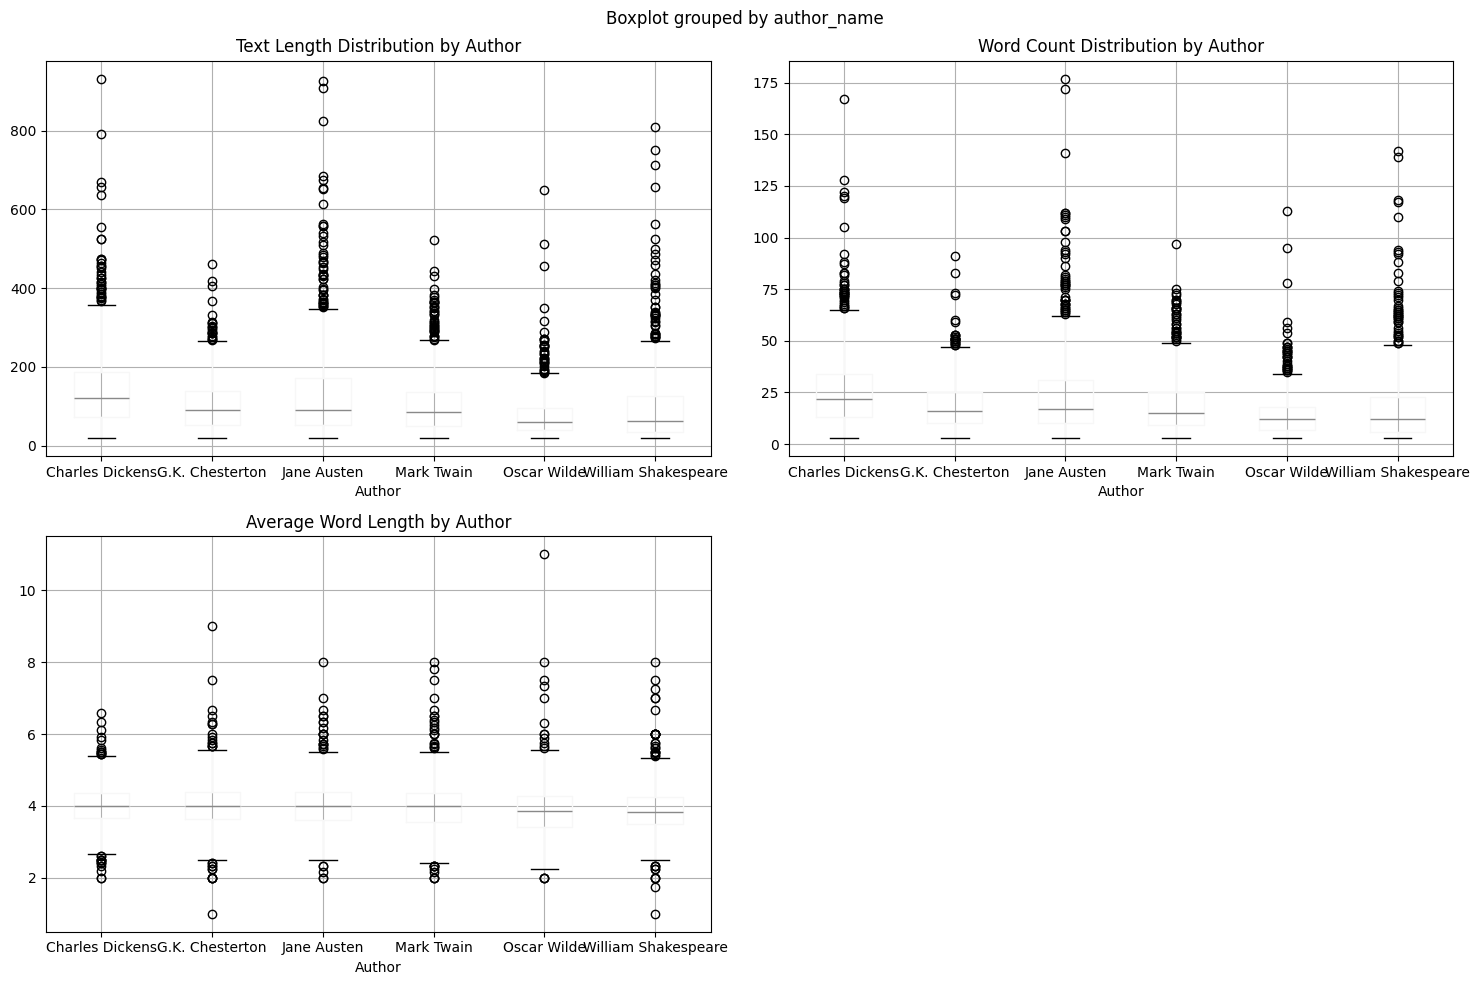

Summary Statistics by Author:
                    text_length         word_count        avg_word_length  \
                           mean     std       mean    std            mean   
author_name                                                                 
Charles Dickens          144.88  106.99      26.25  19.12            4.01   
G.K. Chesterton          104.62   67.39      19.10  12.28            4.03   
Jane Austen              132.31  120.00      23.78  21.06            4.02   
Mark Twain               105.83   77.91      19.30  14.07            3.98   
Oscar Wilde               77.93   58.23      14.62  10.43            3.89   
William Shakespeare       96.28   95.91      18.02  17.40            3.89   

                           
                      std  
author_name                
Charles Dickens      0.58  
G.K. Chesterton      0.71  
Jane Austen          0.67  
Mark Twain           0.73  
Oscar Wilde          0.73  
William Shakespeare  0.71  


In [21]:
def analyze_text_statistics(df):
    """Analyze basic text statistics"""
    # Calculate statistics
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    df['sentence_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
    df['avg_word_length'] = df['text'].apply(
        lambda x: np.mean([len(word) for word in x.split() if word.isalpha()])
    )

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Text length distribution
    df.boxplot(column='text_length', by='author_name', ax=axes[0,0])
    axes[0,0].set_title('Text Length Distribution by Author')
    axes[0,0].set_xlabel('Author')

    # Word count distribution
    df.boxplot(column='word_count', by='author_name', ax=axes[0,1])
    axes[0,1].set_title('Word Count Distribution by Author')
    axes[0,1].set_xlabel('Author')

    # Average word length
    df.boxplot(column='avg_word_length', by='author_name', ax=axes[1,0])
    axes[1,0].set_title('Average Word Length by Author')
    axes[1,0].set_xlabel('Author')

    # Sentence count (for longer texts)
    if df['sentence_count'].max() > 1:
        df.boxplot(column='sentence_count', by='author_name', ax=axes[1,1])
        axes[1,1].set_title('Sentence Count by Author')
        axes[1,1].set_xlabel('Author')
    else:
        axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("Summary Statistics by Author:")
    summary = df.groupby('author_name')[['text_length', 'word_count', 'avg_word_length']].agg(['mean', 'std'])
    print(summary.round(2))

# Analyze sentence dataset
print("=== Sentence-based Dataset Analysis ===")
analyze_text_statistics(sentence_dataset.copy())

## 6. Stylometric Feature Extraction

Let's extract various stylometric features that capture different aspects of writing style.

In [22]:
class StylometricFeatureExtractor:
    """Extract various stylometric features from text"""

    def __init__(self):
        self.stop_words = set(nltk.corpus.stopwords.words('english'))

    def extract_features(self, text):
        """Extract all stylometric features from text"""
        features = {}

        # Basic length features
        features.update(self._length_features(text))

        # Lexical features
        features.update(self._lexical_features(text))

        # Syntactic features
        features.update(self._syntactic_features(text))

        # Punctuation features
        features.update(self._punctuation_features(text))

        # Readability features
        features.update(self._readability_features(text))

        return features

    def _length_features(self, text):
        """Extract length-based features"""
        words = nltk.word_tokenize(text)
        sentences = nltk.sent_tokenize(text)

        alpha_words = [w for w in words if w.isalpha()]

        features = {
            'avg_word_length': np.mean([len(w) for w in alpha_words]) if alpha_words else 0,
            'avg_sentence_length': len(words) / len(sentences) if sentences else 0,
            'max_word_length': max([len(w) for w in alpha_words]) if alpha_words else 0,
            'min_word_length': min([len(w) for w in alpha_words]) if alpha_words else 0,
            'word_length_std': np.std([len(w) for w in alpha_words]) if alpha_words else 0
        }

        return features

    def _lexical_features(self, text):
        """Extract lexical diversity features"""
        words = nltk.word_tokenize(text.lower())
        alpha_words = [w for w in words if w.isalpha()]

        if not alpha_words:
            return {
                'type_token_ratio': 0,
                'hapax_legomena_ratio': 0,
                'simpson_index': 0,
                'long_word_ratio': 0,
                'stop_word_ratio': 0
            }

        word_freq = Counter(alpha_words)
        unique_words = len(word_freq)
        total_words = len(alpha_words)

        # Type-Token Ratio (lexical diversity)
        ttr = unique_words / total_words if total_words > 0 else 0

        # Hapax Legomena (words appearing exactly once)
        hapax = sum(1 for count in word_freq.values() if count == 1)
        hapax_ratio = hapax / unique_words if unique_words > 0 else 0

        # Simpson's Index (another diversity measure)
        simpson = sum((count/total_words)**2 for count in word_freq.values())

        # Long words (> 6 characters)
        long_words = sum(1 for w in alpha_words if len(w) > 6)
        long_word_ratio = long_words / total_words

        # Stop word ratio
        stop_words_count = sum(1 for w in alpha_words if w in self.stop_words)
        stop_word_ratio = stop_words_count / total_words

        features = {
            'type_token_ratio': ttr,
            'hapax_legomena_ratio': hapax_ratio,
            'simpson_index': simpson,
            'long_word_ratio': long_word_ratio,
            'stop_word_ratio': stop_word_ratio
        }

        return features

    def _syntactic_features(self, text):
        """Extract syntactic features using POS tagging"""
        words = nltk.word_tokenize(text)
        if not words:
            return {f'{pos}_ratio': 0 for pos in ['noun', 'verb', 'adj', 'adv', 'prep', 'det']}

        pos_tags = nltk.pos_tag(words)
        pos_counts = Counter([tag for word, tag in pos_tags])
        total_tags = len(pos_tags)

        # Group POS tags into major categories
        noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
        verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
        adj_tags = ['JJ', 'JJR', 'JJS']
        adv_tags = ['RB', 'RBR', 'RBS']
        prep_tags = ['IN', 'TO']
        det_tags = ['DT', 'PDT', 'WDT']

        features = {
            'noun_ratio': sum(pos_counts[tag] for tag in noun_tags) / total_tags,
            'verb_ratio': sum(pos_counts[tag] for tag in verb_tags) / total_tags,
            'adj_ratio': sum(pos_counts[tag] for tag in adj_tags) / total_tags,
            'adv_ratio': sum(pos_counts[tag] for tag in adv_tags) / total_tags,
            'prep_ratio': sum(pos_counts[tag] for tag in prep_tags) / total_tags,
            'det_ratio': sum(pos_counts[tag] for tag in det_tags) / total_tags
        }

        return features

    def _punctuation_features(self, text):
        """Extract punctuation usage features"""
        total_chars = len(text)
        if total_chars == 0:
            return {f'{p}_ratio': 0 for p in ['comma', 'semicolon', 'colon', 'exclamation', 'question', 'period', 'quote']}

        features = {
            'comma_ratio': text.count(',') / total_chars,
            'semicolon_ratio': text.count(';') / total_chars,
            'colon_ratio': text.count(':') / total_chars,
            'exclamation_ratio': text.count('!') / total_chars,
            'question_ratio': text.count('?') / total_chars,
            'period_ratio': text.count('.') / total_chars,
            'quote_ratio': (text.count('"') + text.count("'")) / total_chars
        }

        return features

    def _readability_features(self, text):
        """Extract readability features"""
        try:
            flesch_ease = flesch_reading_ease(text)
            flesch_grade = flesch_kincaid_grade(text)
        except:
            flesch_ease = 0
            flesch_grade = 0

        features = {
            'flesch_reading_ease': flesch_ease,
            'flesch_kincaid_grade': flesch_grade
        }

        return features

# Extract stylometric features
print("Extracting stylometric features...")
feature_extractor = StylometricFeatureExtractor()

# Extract features for a sample of sentences
sample_df = sentence_dataset.head(100).copy()
features_list = []

for idx, row in sample_df.iterrows():
    features = feature_extractor.extract_features(row['text'])
    features['author'] = row['author']
    features['author_name'] = row['author_name']
    features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Extracted {len(features_df.columns)-2} stylometric features")
print("\nFeature columns:", list(features_df.columns[:-2]))

# Display feature statistics by author
print("\nStylometric Feature Analysis:")
feature_cols = [col for col in features_df.columns if col not in ['author', 'author_name']]
author_features = features_df.groupby('author_name')[feature_cols].mean()
print(author_features.round(4))

Extracting stylometric features...
Extracted 25 stylometric features

Feature columns: ['avg_word_length', 'avg_sentence_length', 'max_word_length', 'min_word_length', 'word_length_std', 'type_token_ratio', 'hapax_legomena_ratio', 'simpson_index', 'long_word_ratio', 'stop_word_ratio', 'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 'prep_ratio', 'det_ratio', 'comma_ratio', 'semicolon_ratio', 'colon_ratio', 'exclamation_ratio', 'question_ratio', 'period_ratio', 'quote_ratio', 'flesch_reading_ease', 'flesch_kincaid_grade']

Stylometric Feature Analysis:
                     avg_word_length  avg_sentence_length  max_word_length  \
author_name                                                                  
William Shakespeare           3.9997                23.41             7.74   

                     min_word_length  word_length_std  type_token_ratio  \
author_name                                                               
William Shakespeare             1.69            1.7

## 7. Text Vectorization Approaches

We'll implement different text vectorization methods to convert text into numerical features.

In [23]:
def create_tfidf_features(texts, max_features=5000, ngram_range=(1, 2)):
    """Create TF-IDF features"""
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words='english',
        lowercase=True,
        strip_accents='ascii'
    )

    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    return tfidf_matrix, vectorizer, feature_names

def create_count_features(texts, max_features=5000, ngram_range=(1, 2)):
    """Create Count Vectorizer features"""
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words='english',
        lowercase=True,
        strip_accents='ascii'
    )

    count_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    return count_matrix, vectorizer, feature_names

def analyze_most_distinctive_features(tfidf_matrix, feature_names, labels, top_k=10):
    """Find most distinctive features for each author"""
    authors = np.unique(labels)

    print("Most Distinctive Features by Author:")
    print("=" * 50)

    for author in authors:
        # Get average TF-IDF scores for this author
        author_mask = (labels == author)
        author_tfidf = tfidf_matrix[author_mask].mean(axis=0).A1

        # Get average TF-IDF scores for other authors
        other_mask = ~author_mask
        other_tfidf = tfidf_matrix[other_mask].mean(axis=0).A1

        # Calculate distinctiveness (difference)
        distinctiveness = author_tfidf - other_tfidf

        # Get top distinctive features
        top_indices = np.argsort(distinctiveness)[-top_k:]
        top_features = [(feature_names[i], distinctiveness[i]) for i in reversed(top_indices)]

        print(f"\n{author}:")
        for feature, score in top_features:
            print(f"  {feature}: {score:.4f}")

# Prepare data
X_text = sentence_dataset['text'].values
y = sentence_dataset['author'].values
author_names = sentence_dataset['author_name'].values

print(f"Dataset size: {len(X_text)} samples")
print(f"Authors: {np.unique(author_names)}")

# Create different vectorizations
print("\nCreating TF-IDF features...")
X_tfidf, tfidf_vectorizer, tfidf_features = create_tfidf_features(X_text, max_features=3000)
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

print("\nCreating Count features...")
X_count, count_vectorizer, count_features = create_count_features(X_text, max_features=3000)
print(f"Count matrix shape: {X_count.shape}")

# Analyze distinctive features
analyze_most_distinctive_features(X_tfidf, tfidf_features, author_names)

Dataset size: 4800 samples
Authors: ['Charles Dickens' 'G.K. Chesterton' 'Jane Austen' 'Mark Twain'
 'Oscar Wilde' 'William Shakespeare']

Creating TF-IDF features...
TF-IDF matrix shape: (4800, 3000)

Creating Count features...
Count matrix shape: (4800, 3000)
Most Distinctive Features by Author:

Charles Dickens:
  defarge: 0.0152
  mr: 0.0136
  lorry: 0.0131
  mr lorry: 0.0118
  carton: 0.0114
  madame: 0.0105
  hand: 0.0104
  manette: 0.0090
  doctor: 0.0089
  lucie: 0.0085

G.K. Chesterton:
  turnbull: 0.0340
  macian: 0.0278
  said: 0.0202
  evan: 0.0159
  man: 0.0127
  god: 0.0125
  don: 0.0102
  like: 0.0096
  quite: 0.0091
  said macian: 0.0082

Jane Austen:
  mrs: 0.0228
  emma: 0.0151
  elinor: 0.0141
  think: 0.0123
  miss: 0.0121
  sure: 0.0120
  dear: 0.0119
  mr: 0.0111
  harriet: 0.0110
  marianne: 0.0098

Mark Twain:
  tom: 0.0490
  huck: 0.0219
  dont: 0.0181
  boys: 0.0151
  aint: 0.0130
  joe: 0.0129
  got: 0.0126
  just: 0.0103
  thats: 0.0094
  chapter: 0.0092

Os

## 8. Author Classification Models

Let's build and compare different classification models for author identification.

Training set: 3840 samples
Test set: 960 samples

Logistic Regression Results:
Accuracy: 0.6708

Classification Report:
              precision    recall  f1-score   support

      austen       0.64      0.63      0.63       160
  chesterton       0.67      0.68      0.67       160
     dickens       0.62      0.69      0.65       160
 shakespeare       0.90      0.82      0.86       160
       twain       0.71      0.64      0.67       160
       wilde       0.53      0.57      0.55       160

    accuracy                           0.67       960
   macro avg       0.68      0.67      0.67       960
weighted avg       0.68      0.67      0.67       960


Random Forest Results:
Accuracy: 0.6031

Classification Report:
              precision    recall  f1-score   support

      austen       0.62      0.56      0.59       160
  chesterton       0.61      0.56      0.59       160
     dickens       0.61      0.57      0.59       160
 shakespeare       0.84      0.78      0.81       160
 

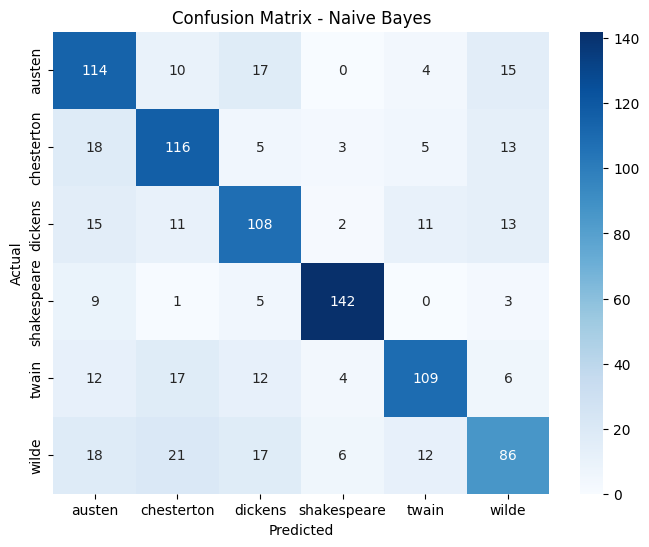

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a classification model"""
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model, accuracy, y_pred

def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    trained_model, accuracy, predictions = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    results[name] = {
        'model': trained_model,
        'accuracy': accuracy,
        'predictions': predictions
    }

# Compare results
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
for name, result in results.items():
    print(f"{name}: {result['accuracy']:.4f}")

# Plot confusion matrix for best model
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_predictions = results[best_model_name]['predictions']

unique_authors = np.unique(y)
plot_confusion_matrix(y_test, best_predictions, unique_authors,
                     f'Confusion Matrix - {best_model_name}')

## 9. Feature Importance Analysis

In [25]:
def analyze_feature_importance(model, feature_names, top_k=20):
    """Analyze feature importance for the model"""
    if hasattr(model, 'coef_'):
        # For linear models (Logistic Regression, SVM)
        if len(model.coef_.shape) > 1:  # Multi-class
            # Average absolute coefficients across classes
            importance = np.mean(np.abs(model.coef_), axis=0)
        else:
            importance = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        # For tree-based models (Random Forest)
        importance = model.feature_importances_
    else:
        print("Feature importance not available for this model type")
        return

    # Get top features
    top_indices = np.argsort(importance)[-top_k:]
    top_features = [(feature_names[i], importance[i]) for i in reversed(top_indices)]

    print(f"Top {top_k} Most Important Features:")
    print("-" * 40)
    for i, (feature, score) in enumerate(top_features, 1):
        print(f"{i:2d}. {feature}: {score:.4f}")

    # Plot feature importance
    features, scores = zip(*top_features)

    plt.figure(figsize=(10, 8))
    y_pos = np.arange(len(features))
    plt.barh(y_pos, scores)
    plt.yticks(y_pos, features)
    plt.xlabel('Importance Score')
    plt.title('Top Features by Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Analyze feature importance for best model
best_model = results[best_model_name]['model']
print(f"Feature importance analysis for {best_model_name}:")
analyze_feature_importance(best_model, tfidf_features)

Feature importance analysis for Naive Bayes:
Feature importance not available for this model type


## 10. Cross-Validation and Hyperparameter Tuning

In [26]:
def perform_grid_search(X, y, model_params, cv=5):
    """Perform grid search for hyperparameter tuning"""
    results = {}

    for model_name, (model, param_grid) in model_params.items():
        print(f"\nTuning {model_name}...")

        grid_search = GridSearchCV(
            model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1
        )

        grid_search.fit(X, y)

        results[model_name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'best_model': grid_search.best_estimator_
        }

        print(f"Best score: {grid_search.best_score_:.4f}")
        print(f"Best params: {grid_search.best_params_}")

    return results

# Define parameter grids for tuning
param_grids = {
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000), {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }),
    'SVM': (SVC(random_state=42), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    })
}

# Perform grid search on a subset for speed
X_subset = X_tfidf[:1000]  # Use subset for faster tuning
y_subset = y[:1000]

print("Performing hyperparameter tuning...")
tuning_results = perform_grid_search(X_subset, y_subset, param_grids)

# Compare tuned vs default models
print("\n" + "="*60)
print("TUNED MODEL COMPARISON")
print("="*60)
for name, result in tuning_results.items():
    print(f"{name}:")
    print(f"  Best CV Score: {result['best_score']:.4f}")
    print(f"  Best Parameters: {result['best_params']}")
    print()

Performing hyperparameter tuning...

Tuning Logistic Regression...
Best score: 0.9080
Best params: {'C': 100, 'solver': 'liblinear'}

Tuning Random Forest...
Best score: 0.8850
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}

Tuning SVM...
Best score: 0.8990
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

TUNED MODEL COMPARISON
Logistic Regression:
  Best CV Score: 0.9080
  Best Parameters: {'C': 100, 'solver': 'liblinear'}

Random Forest:
  Best CV Score: 0.8850
  Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}

SVM:
  Best CV Score: 0.8990
  Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}



## 11. Model Interpretation and Examples

In [27]:
def predict_author_with_confidence(text, model, vectorizer, label_encoder=None):
    """Predict author with confidence scores"""
    # Vectorize text
    text_vector = vectorizer.transform([text])

    # Get prediction
    prediction = model.predict(text_vector)[0]

    # Get confidence scores if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_vector)[0]
        classes = model.classes_

        # Create confidence dict
        confidence = {classes[i]: prob for i, prob in enumerate(probabilities)}
    else:
        confidence = {prediction: 1.0}

    return prediction, confidence

def demonstrate_predictions():
    """Demonstrate model predictions on sample texts"""
    # Get best model
    best_model = results[best_model_name]['model']

    # Sample texts from test set - fix for sparse matrix handling
    if hasattr(X_test, 'shape'):
        # Handle sparse matrix properly
        test_size = X_test.shape[0]
        test_indices = np.random.choice(range(test_size), min(5, test_size), replace=False)
    else:
        test_indices = np.random.choice(range(len(X_test)), 5, replace=False)

    print("Sample Predictions:")
    print("=" * 80)

    for i, idx in enumerate(test_indices):
        # Get original text - handle the sparse matrix index issue
        if idx < len(sentence_dataset):
            # Use the original sentence dataset to get the text
            text_sample = sentence_dataset.iloc[idx]['text']
            true_author = y_test[idx]
        else:
            # Fallback to a sample from the dataset
            sample_idx = idx % len(sentence_dataset)
            text_sample = sentence_dataset.iloc[sample_idx]['text']
            true_author = sentence_dataset.iloc[sample_idx]['author']

        # Make prediction
        pred_author, confidence = predict_author_with_confidence(
            text_sample, best_model, tfidf_vectorizer
        )

        print(f"\nExample {i+1}:")
        print(f"Text: {text_sample[:200]}..." if len(text_sample) > 200 else f"Text: {text_sample}")
        print(f"True Author: {true_author}")
        print(f"Predicted Author: {pred_author}")
        print(f"Correct: {'✓' if pred_author == true_author else '✗'}")

        # Show confidence scores
        print("Confidence scores:")
        for author, score in sorted(confidence.items(), key=lambda x: x[1], reverse=True):
            print(f"  {author}: {score:.3f}")
        print("-" * 80)

demonstrate_predictions()

Sample Predictions:

Example 1:
Text: All which Sir, though I most powerfully, and potently beleeue; yet I holde it not Honestie to haue it thus set downe: For you your selfe Sir, should be old as I am, if like a Crab you could go backwar...
True Author: austen
Predicted Author: shakespeare
Correct: ✗
Confidence scores:
  shakespeare: 0.886
  chesterton: 0.027
  dickens: 0.025
  wilde: 0.023
  austen: 0.021
  twain: 0.018
--------------------------------------------------------------------------------

Example 2:
Text: But Mr Elliot was not done with.
True Author: dickens
Predicted Author: austen
Correct: ✗
Confidence scores:
  austen: 0.675
  dickens: 0.098
  wilde: 0.069
  chesterton: 0.065
  twain: 0.054
  shakespeare: 0.040
--------------------------------------------------------------------------------

Example 3:
Text: who knowes it, when none can call our powre to accompt: yet who would haue thought the olde man to haue had so much blood in him Doct.
True Author: wilde
Predicted

---

# Challenge Section



## Challenge 1: Advanced Stylometric Features

Implement additional sophisticated stylometric features that could improve author identification.

**Tasks:**
1. Implement dependency parsing features (using spaCy)
2. Add word complexity measures (syllable count, rare word usage)
3. Extract rhythm and cadence features (stress patterns)
4. Implement semantic coherence measures
5. Compare performance with baseline features

In [28]:
# TODO: Implement advanced stylometric features
class AdvancedStylometricExtractor:
    def __init__(self):
        # Initialize any required resources (e.g., spaCy model)
        pass

    def extract_dependency_features(self, text):
        """
        Extract features based on dependency parsing
        - Average dependency tree depth
        - Frequency of different dependency relations
        - Sentence complexity measures
        """
        # Your implementation here
        pass

    def extract_complexity_features(self, text):
        """
        Extract word and sentence complexity features
        - Average syllable count per word
        - Frequency of rare/complex words
        - Lexical sophistication measures
        """
        # Your implementation here
        pass

    def extract_rhythm_features(self, text):
        """
        Extract rhythm and cadence features
        - Stress pattern analysis
        - Syllable rhythm patterns
        - Sentence rhythm variability
        """
        # Your implementation here
        pass

    def extract_semantic_features(self, text):
        """
        Extract semantic coherence and topic features
        - Topic consistency measures
        - Semantic similarity between sentences
        - Abstract vs concrete word usage
        """
        # Your implementation here
        pass

# TODO: Compare advanced features with baseline
# Your implementation and evaluation here

## Challenge 2: Deep Learning Approach

Implement a neural network-based approach for authorship attribution.

**Tasks:**
1. Build a CNN-based model for character-level analysis
2. Implement an LSTM model for sequence-level features
3. Create a Transformer-based model using pre-trained embeddings
4. Compare deep learning approaches with traditional ML methods
5. Analyze what the neural networks learn about writing style

In [29]:
# TODO: Implement deep learning models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class CharacterCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(CharacterCNN, self).__init__()
        # TODO: Implement CNN for character-level analysis
        pass

    def forward(self, x):
        # TODO: Implement forward pass
        pass

class AuthorLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(AuthorLSTM, self).__init__()
        # TODO: Implement LSTM for sequence analysis
        pass

    def forward(self, x):
        # TODO: Implement forward pass
        pass

class TransformerClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super(TransformerClassifier, self).__init__()
        # TODO: Implement transformer-based classifier
        pass

    def forward(self, x):
        # TODO: Implement forward pass
        pass

# TODO: Training and evaluation functions
def train_deep_model(model, train_loader, val_loader, epochs=10):
    # Your implementation here
    pass

def evaluate_deep_model(model, test_loader):
    # Your implementation here
    pass

## Challenge 3: Cross-Domain Author Attribution

Test the robustness of your models across different text domains and time periods.

**Tasks:**
1. Collect texts from different genres (fiction, non-fiction, poetry, journalism)
2. Analyze how writing style changes over time periods
3. Build domain-adaptive models
4. Evaluate cross-domain generalization
5. Implement domain adaptation techniques

In [30]:
# TODO: Implement cross-domain analysis
def collect_multi_domain_texts():
    """
    Collect texts from different domains:
    - Fiction vs Non-fiction
    - Different time periods
    - Different genres
    """
    # Your implementation here
    pass

def analyze_domain_shift(source_domain_data, target_domain_data):
    """
    Analyze how stylometric features change across domains
    """
    # Your implementation here
    pass

def build_domain_adaptive_model(source_data, target_data):
    """
    Build models that can adapt across domains
    """
    # Your implementation here
    pass

# TODO: Evaluate cross-domain performance
def evaluate_cross_domain_performance(models, datasets):
    # Your implementation here
    pass

## Challenge 4: Authorship Verification vs Attribution

Implement authorship verification (binary: same author or not) in addition to attribution (multi-class).

**Tasks:**
1. Reformulate the problem as verification (1-vs-all)
2. Implement Siamese networks for similarity learning
3. Use distance-based methods for verification
4. Compare verification vs attribution performance
5. Implement few-shot learning for new authors

In [31]:
# TODO: Implement authorship verification
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SiameseNetwork, self).__init__()
        # TODO: Implement Siamese network for similarity learning
        pass

    def forward(self, x1, x2):
        # TODO: Implement forward pass for pair of texts
        pass

def create_verification_dataset(attribution_data):
    """
    Create pairs of texts with same/different author labels
    """
    # Your implementation here
    pass

def distance_based_verification(text1, text2, model, threshold=0.5):
    """
    Verify if two texts are by the same author using distance metrics
    """
    # Your implementation here
    pass

def few_shot_author_learning(support_texts, query_text, k=5):
    """
    Learn to identify a new author from few examples
    """
    # Your implementation here
    pass

## Challenge 5: Adversarial Authorship

Explore how authors might try to disguise their writing style and how to make models robust to such attempts.

**Tasks:**
1. Simulate style transfer attacks (making text look like another author)
2. Implement adversarial training for robustness
3. Analyze which features are most vulnerable to manipulation
4. Develop detection methods for style mimicry
5. Build robust features that resist manipulation

In [32]:
# TODO: Implement adversarial authorship analysis
def simulate_style_transfer(source_text, target_author_style):
    """
    Simulate attempts to disguise writing style
    - Vocabulary substitution
    - Sentence structure changes
    - Punctuation modification
    """
    # Your implementation here
    pass

def adversarial_training(model, training_data, attack_function):
    """
    Train model to be robust against style manipulation
    """
    # Your implementation here
    pass

def analyze_feature_vulnerability(features, attack_methods):
    """
    Analyze which stylometric features are most vulnerable
    """
    # Your implementation here
    pass

def detect_style_mimicry(text, suspected_true_author, claimed_author):
    """
    Detect if text has been artificially modified to mimic another style
    """
    # Your implementation here
    pass

## Challenge 6: Real-World Application

Build a practical authorship attribution system for a specific use case.

**Tasks:**
1. Choose a specific application (plagiarism detection, forensics, etc.)
2. Collect appropriate real-world data
3. Handle practical challenges (short texts, noisy data, unknown authors)
4. Build an end-to-end system with user interface
5. Evaluate on realistic scenarios

In [33]:
# TODO: Implement real-world application
class AuthorshipAttributionSystem:
    def __init__(self):
        self.models = {}
        self.vectorizers = {}
        self.author_profiles = {}

    def train_system(self, training_data):
        """
        Train the complete authorship attribution system
        """
        # Your implementation here
        pass

    def predict_author(self, text, return_confidence=True):
        """
        Predict the author of a given text
        """
        # Your implementation here
        pass

    def handle_unknown_author(self, text):
        """
        Detect when text is from an unknown author
        """
        # Your implementation here
        pass

    def handle_short_text(self, text):
        """
        Handle attribution for very short texts
        """
        # Your implementation here
        pass

    def update_author_profile(self, author, new_texts):
        """
        Update author profile with new writing samples
        """
        # Your implementation here
        pass

# TODO: Build user interface
def create_web_interface():
    """
    Create a web interface for the authorship attribution system
    """
    # You can use Gradio or Streamlit for this
    pass

## Challenge 7: Analysis Questions

Answer these questions based on your experiments:

1. **Feature Effectiveness**: Which types of stylometric features are most effective for author identification? Why?

2. **Text Length Impact**: How does the length of text samples affect attribution accuracy? What's the minimum viable length?

3. **Genre Effects**: How does writing genre affect the effectiveness of different features?

4. **Temporal Stability**: How stable are writing styles over time? What challenges does this pose?

5. **Privacy Implications**: What are the privacy and ethical implications of authorship attribution technology?

6. **Robustness**: How can we make authorship attribution systems more robust to deliberate deception?

7. **Future Directions**: What are the most promising research directions in computational stylometry?

### Your Answers:

**1. Feature Effectiveness:**
<!-- Your analysis here -->

**2. Text Length Impact:**
<!-- Your analysis here -->

**3. Genre Effects:**
<!-- Your analysis here -->

**4. Temporal Stability:**
<!-- Your analysis here -->

**5. Privacy Implications:**
<!-- Your analysis here -->

**6. Robustness:**
<!-- Your analysis here -->

**7. Future Directions:**
<!-- Your analysis here -->

## Bonus Challenge: Multi-Modal Authorship Attribution

Extend beyond text to include other modalities that might reveal authorship.

**Tasks:**
1. Analyze typing patterns and timing (if available)
2. Include metadata features (posting times, frequency patterns)
3. Combine textual and behavioral features
4. Explore cross-modal consistency in authorship
5. Build multi-modal fusion models

In [34]:
# TODO: Implement multi-modal authorship attribution
class MultiModalAuthorshipModel:
    def __init__(self):
        self.text_model = None
        self.behavioral_model = None
        self.fusion_model = None

    def extract_behavioral_features(self, metadata):
        """
        Extract behavioral features from metadata:
        - Posting time patterns
        - Writing frequency
        - Response time patterns
        - Activity patterns
        """
        # Your implementation here
        pass

    def extract_typing_features(self, keystroke_data):
        """
        Extract typing pattern features:
        - Dwell time (key press duration)
        - Flight time (between key presses)
        - Typing rhythm patterns
        """
        # Your implementation here
        pass

    def fuse_modalities(self, text_features, behavioral_features, typing_features):
        """
        Combine features from different modalities
        """
        # Your implementation here
        pass